## Analytical solutions to stagnational flow in a glacier that flows against a steeply adverse bed

#### Stream function solution using conformal mapping

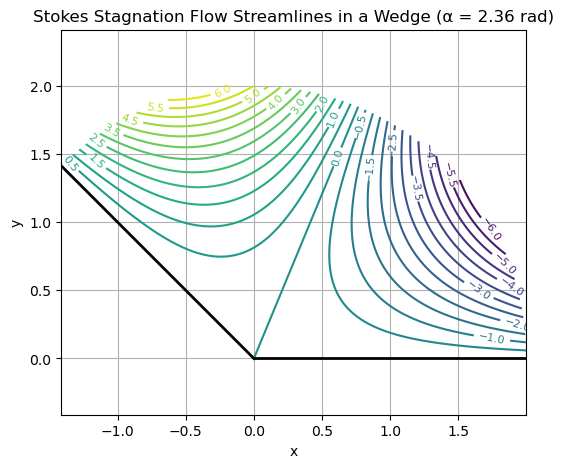

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
A = -1.0               # Streamfunction amplitude
alpha =3*np.pi / 4     # Wedge angle in radians (change as needed)

# Create polar grid
r = np.linspace(0.01, 2.0, 500)
theta = np.linspace(1e-3, alpha - 1e-3, 500)
R, Theta = np.meshgrid(r, theta)

# Compute streamfunction in polar coordinates
psi = A * R**(2 * np.pi / alpha) * np.sin((2 * np.pi / alpha) * Theta)

# Convert to Cartesian for plotting
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

# Plot streamlines (contours of psi)
plt.figure(figsize=(6, 5))
contours = plt.contour(X, Y, psi, levels=30, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)
plt.title(f"Stokes Stagnation Flow Streamlines in a Wedge (α = {alpha:.2f} rad)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.plot([0, plt.ylim()[1]], [0, 0], 'k-', lw=2)  # Wedge boundary
plt.plot([plt.xlim()[0], 0], [plt.xlim()[0]*np.tan(alpha), 0], 'k-', lw=2)  # Wedge boundary
plt.show()


#### Velocity components

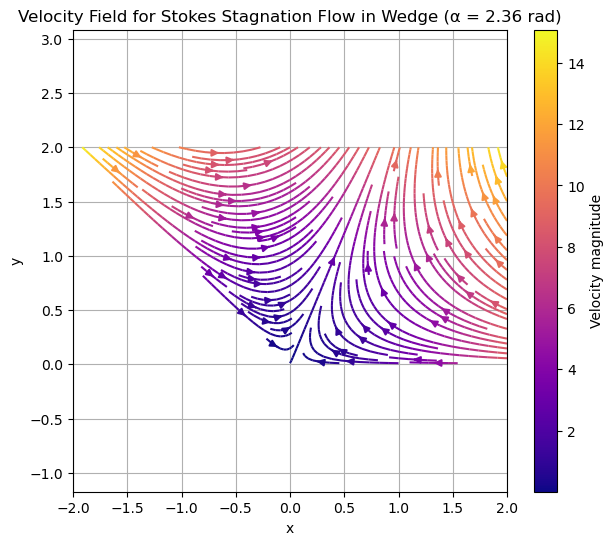

In [2]:
# Create Cartesian grid
x = np.linspace(-2, 2, 300)
y = np.linspace(0.01, 2.0, 300)  # Stay within wedge (upper half-plane)
Xc, Yc = np.meshgrid(x, y)

# Convert to polar coordinates
Rc = np.sqrt(Xc**2 + Yc**2)
Thetac = np.arctan2(Yc, Xc)

# Mask points outside the wedge (θ ∉ (0, α))
mask = (Thetac <= 0) | (Thetac >= alpha)
Rc[mask] = np.nan
Thetac[mask] = np.nan

# Compute velocity components in polar coordinates
dpsi_dtheta = A * Rc**(2 * np.pi / alpha) * (2 * np.pi / alpha) * np.cos((2 * np.pi / alpha) * Thetac)
dpsi_dr = A * (2 * np.pi / alpha) * Rc**(2 * np.pi / alpha - 1) * np.sin((2 * np.pi / alpha) * Thetac)

u_r = (1 / Rc) * dpsi_dtheta
u_theta = -dpsi_dr

# Convert to Cartesian components
u_x = u_r * np.cos(Thetac) - u_theta * np.sin(Thetac)
u_y = u_r * np.sin(Thetac) + u_theta * np.cos(Thetac)

# Plot the velocity field
plt.figure(figsize=(7, 6))
plt.streamplot(x, y, u_x, u_y, color=np.sqrt(u_x**2 + u_y**2), cmap='plasma', density=1.5)
plt.title(f"Velocity Field for Stokes Stagnation Flow in Wedge (α = {alpha:.2f} rad)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.colorbar(label='Velocity magnitude')
plt.show()


#### Stresses and stress gradients
##### Are "bridging" terms important?

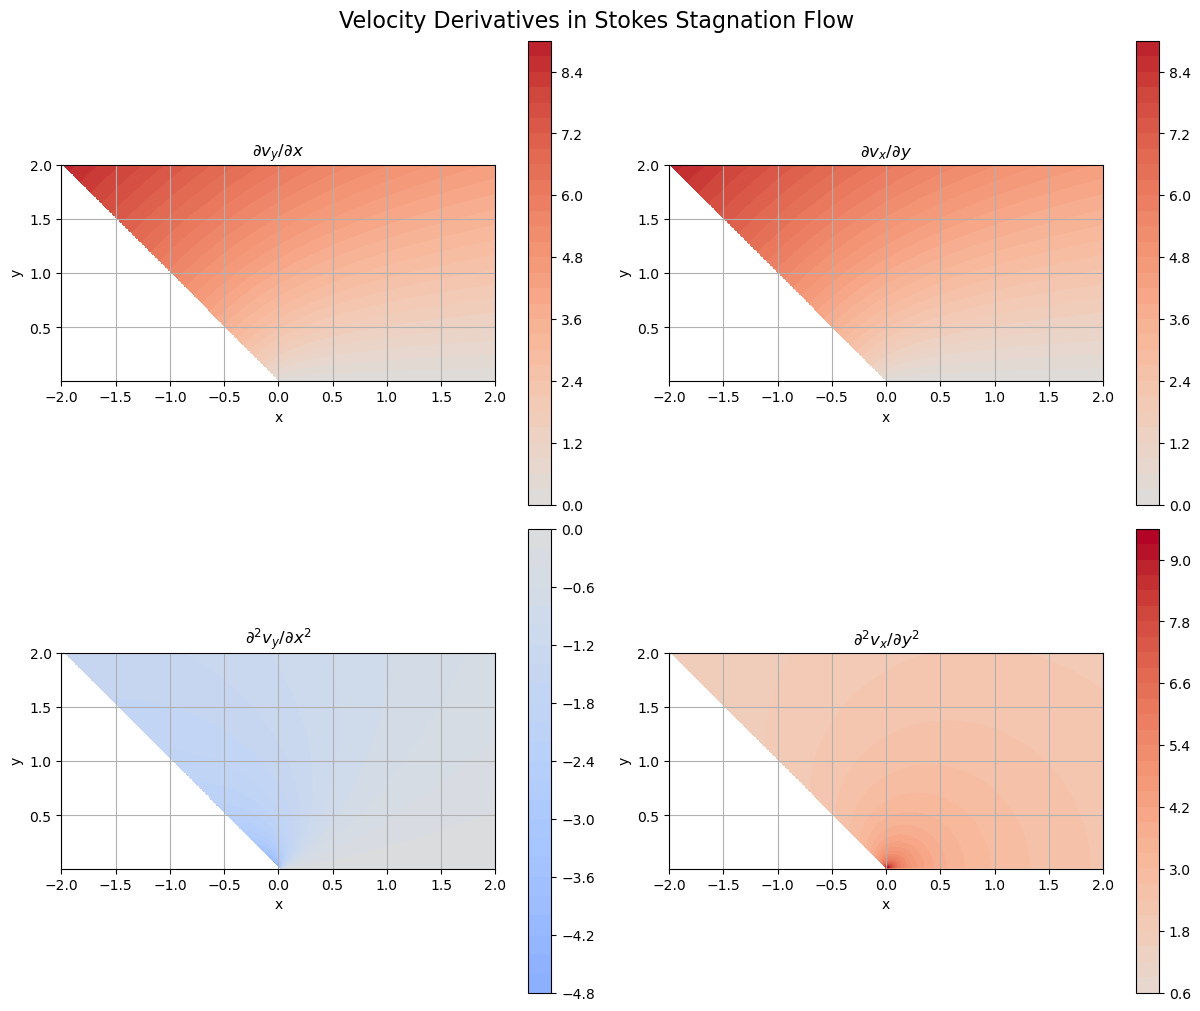

In [3]:
# Compute spatial steps
dx = x[1] - x[0]
dy = y[1] - y[0]

# First derivatives
dvy_dx = np.gradient(u_y, dx, axis=1)
dvx_dy = np.gradient(u_x, dy, axis=0)

# Second derivatives
d2vy_dx2 = np.gradient(np.gradient(u_y, dx, axis=1), dx, axis=1)
d2vx_dy2 = np.gradient(np.gradient(u_x, dy, axis=0), dy, axis=0)

# Get max absolute value across all fields for symmetric color scale
vmax = np.nanmax([
    np.abs(dvy_dx),
    np.abs(dvx_dy),
    np.abs(d2vy_dx2),
    np.abs(d2vx_dy2)
])

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

fields = [
    (dvy_dx, r'$\partial v_y / \partial x$'),
    (dvx_dy, r'$\partial v_x / \partial y$'),
    (d2vy_dx2, r'$\partial^2 v_y / \partial x^2$'),
    (d2vx_dy2, r'$\partial^2 v_x / \partial y^2$')
]

for ax, (field, title) in zip(axes.flatten(), fields):
    cs = ax.contourf(Xc, Yc, field, levels=30, cmap='coolwarm', vmin=-vmax, vmax=vmax)
    fig.colorbar(cs, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')
    ax.grid(True)

plt.suptitle("Velocity Derivatives in Stokes Stagnation Flow", fontsize=16)
plt.show()


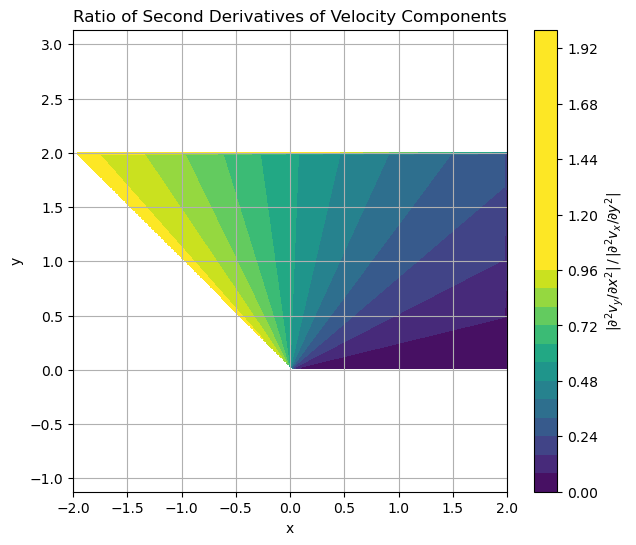

In [4]:
# Small epsilon to avoid division by zero
epsilon = 1e-12

# Compute absolute value ratio
ratio = np.abs(d2vy_dx2) / (np.abs(d2vx_dy2) + epsilon)

# Mask invalid values (outside wedge or due to NaNs)
ratio = np.where(np.isnan(ratio), np.nan, ratio)

# Plot
plt.figure(figsize=(7, 6))
cs = plt.contourf(Xc, Yc, ratio, levels=30, cmap='viridis',vmax=1)
plt.colorbar(cs, label=r'$|\partial^2 v_y / \partial x^2| \, / \, |\partial^2 v_x / \partial y^2|$')
plt.title("Ratio of Second Derivatives of Velocity Components")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.show()


#### Pressure (def not hydrostatic...)

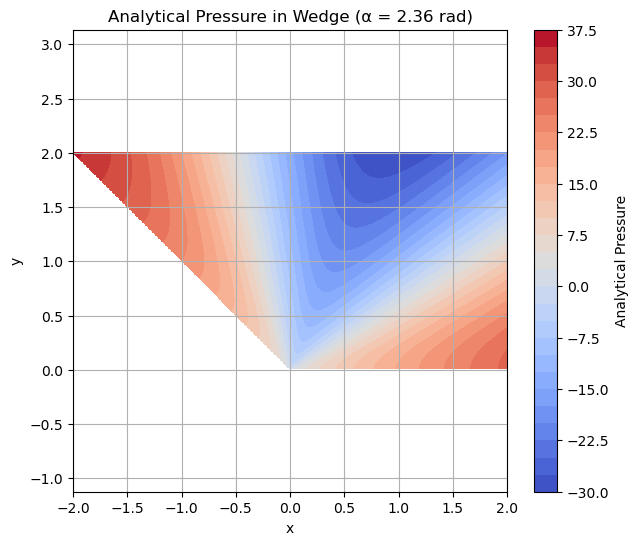

In [25]:
# Constants (should already be defined)
lambda_ = 2 * np.pi / alpha
mu = 1.0  # Viscosity (arbitrary units)

# Compute polar coordinates from Cartesian grid
Rc = np.sqrt(Xc**2 + Yc**2)
Thetac = np.arctan2(Yc, Xc)

# Mask points outside the wedge
mask = (Thetac <= 0) | (Thetac >= alpha)
Rc_masked = np.where(mask, np.nan, Rc)
Thetac_masked = np.where(mask, np.nan, Thetac)

# Compute analytical pressure
p_analytical = -4 * mu * A * lambda_ * (lambda_ - 1) * Rc_masked**(lambda_ - 2) * np.cos(lambda_ * Thetac_masked)

# Normalize for plotting
p_analytical -= np.nanmean(p_analytical)

# Plot
plt.figure(figsize=(7, 6))
cs = plt.contourf(Xc, Yc, p_analytical, levels=30, cmap='coolwarm')
plt.colorbar(cs, label='Analytical Pressure')
plt.title(f"Analytical Pressure in Wedge (α = {alpha:.2f} rad)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.show()
